In [351]:
%pylab inline
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

Populating the interactive namespace from numpy and matplotlib


We first build surrogate data to apply dPCA to.

In [352]:
# number of neurons, time-points and stimuli
N,T,S = 2,250,6

# noise-level and number of trials in each condition
noise, n_samples = 0.1, 10

# build two latent factors
zt = (arange(T)/float(T))
zs = (arange(S)/float(S))

# build trial-by trial data
trialR = noise*randn(n_samples,N,S,T)
trialR += randn(N)[None,:,None,None]*zt[None,None,None,:]
trialR += randn(N)[None,:,None,None]*zs[None,None,:,None]

# trial-average data
R = mean(trialR,0)

# center data
R -= mean(R.reshape((N,-1)),1)[:,None,None]

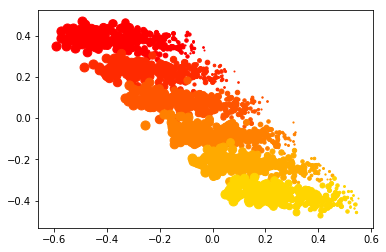

In [353]:
import matplotlib as mpl


cmap = mpl.cm.autumn
for s in range (S):
    for t in range(T):
        scatter(R[0,s,t], R[1,s,t],s=t/3+1,color=cmap(s / float(S)))

            
#print('latent time '+ str(zt))
#print('latent stimuli '+ str(zs))


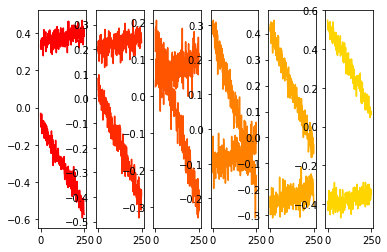

In [354]:
for s in range (S):
    for n in range(N):
        subplot(1,S,s+1)
        plot(R[n,s,:], color=cmap(s / float(S)))

In [355]:
shape(R)

(2, 6, 250)

We then instantiate a dPCA model where the two parameter axis are labeled by 's' (stimulus) and 't' (time) respectively. We set regularizer to 'auto' to optimize the regularization parameter when we fit the data.

In [356]:
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


Now fit the data (R) using the model we just instatiated. Note that we only need trial-to-trial data when we want to optimize over the regularization parameter.

In [357]:
Z = dpca.fit_transform(R,trialR)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.03571620900974838
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [358]:
E, D = dpca._randomized_dpca(R, Z)

In [359]:
shape(Z['s'])

(2, 6, 250)

In [360]:
shape(D['s'])
print(D['s'])
print(D['t'])
print(E['s'])
print(E['t'])

[[-3.46361458e-01  1.85137352e-05]
 [ 6.63019965e-01  1.70556912e-05]]
[[0.25918806 0.00157782]
 [0.12616455 0.00237617]]
[[ 1.0000000e+00  1.9518271e-06]
 [-1.9518271e-06  1.0000000e+00]]
[[ 0.99998578  0.00533214]
 [-0.00533214  0.99998578]]


In [361]:
D['s'][:,0]

array([-0.34636146,  0.66301996])

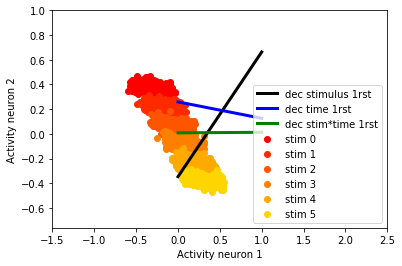

In [362]:
time = arange(T)

for s in range (S):
    scatter (R[0,s], R[1,s], label='stim '+str(s), color=cmap(s / float(S)))

x = [-0.2, 0.3]

plot(D['s'][:, 0], lw=3, c='k', label='dec stimulus 1rst')
plot(D['t'][:, 0], lw=3, c='b', label='dec time 1rst')
#plot(D['t'][:, 1], lw=3, c='b', label='dec time 1rst')
plot(D['st'][:, 0], lw=3, c='g', label='dec stim*time 1rst')

#plot(E['s'], lw=3, c='b', label='encoder axis')
    
xlabel('Activity neuron 1')    
ylabel('Activity neuron 2')
xlim(-1.5, 2.5)
ylim(-0.76, 1.)
legend()
show()

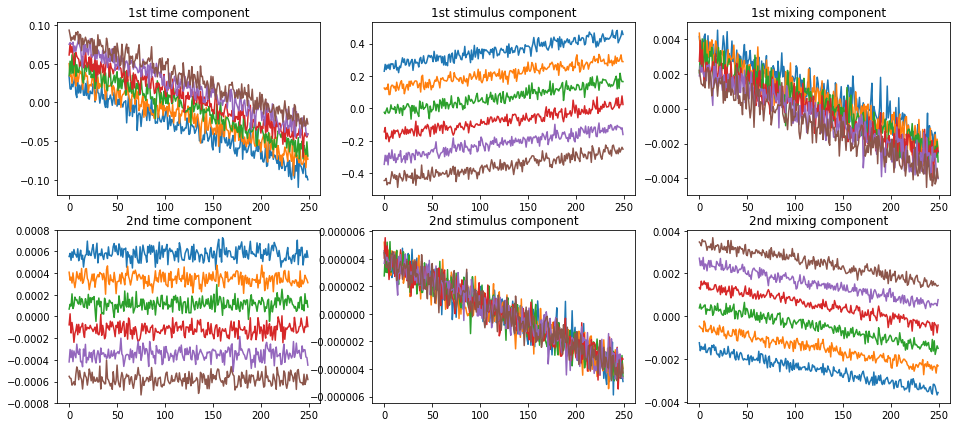

In [363]:
time = arange(T)

figure(figsize=(16,7))
subplot(231)

for s in range(S):
    plot(time,Z['t'][0,s])

title('1st time component')


subplot(234)

for s in range(S):
    plot(time,Z['t'][1,s])

title('2nd time component')
    
subplot(232)

for s in range(S):
    plot(time,Z['s'][0,s])
    
title('1st stimulus component')

subplot(235)

for s in range(S):
    plot(time,Z['s'][1,s])
    
title('2nd stimulus component')
    
subplot(233)

for s in range(S):
    plot(time,Z['st'][0,s])
    
title('1st mixing component')

subplot(236)

for s in range(S):
    plot(time,Z['st'][1,s])
    
title('2nd mixing component')
show()

The 1st mixing component looks merely like noise. But to be sure, we can run a significance analysis:

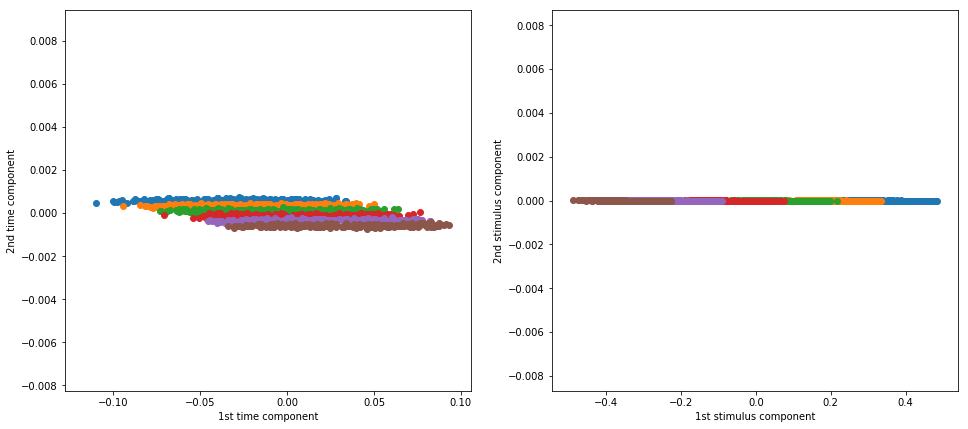

In [364]:
figure(figsize=(16,7))
subplot (121)
for s in range(S):
    scatter(Z['t'][0, s], Z['t'][1, s])
    
#plot(E['t'], c='k', lw=5)
xlabel('1st time component')
ylabel('2nd time component')

subplot (122)
for s in range(S):
    scatter(Z['s'][0, s], Z['s'][1, s])
#plot(E['s'], c='k', lw=5)
xlabel('1st stimulus component')
ylabel('2nd stimulus component')
show()

In [365]:
shape(trialR)

(10, 2, 6, 250)

In [366]:
significance_masks = dpca.significance_analysis(R,trialR,axis='t',n_shuffles=10,n_splits=10,n_consecutive=10)

AttributeError: 'dPCA' object has no attribute 'significance_analysis1'

We can highlight the significant parts of the demixed components with a black bar underneath. Note that there is no significant analysis time, since there are no classes to compute the significance over.

NameError: name 'significance_masks' is not defined

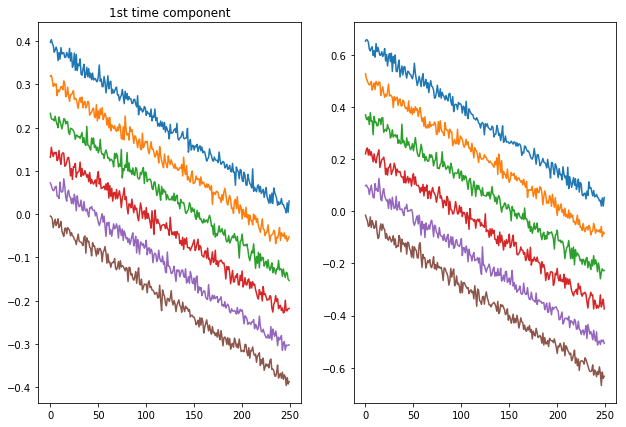

In [306]:
time = arange(T)

figure(figsize=(16,7))
subplot(131)

for s in range(S):
    plot(time,Z['t'][0,s])

title('1st time component')
    
subplot(132)

for s in range(S):
    plot(time,Z['s'][0,s])

imshow(significance_masks['s'][0][None,:],extent=[0,250,amin(Z['s'])-1,amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['s'])-1,amax(Z['s'])+1])

title('1st stimulus component')
    
subplot(133)

for s in range(S):
    plot(time,Z['st'][0,s])

dZ = amax(Z['st'])-amin(Z['st'])
imshow(significance_masks['st'][0][None,:],extent=[0,250,amin(Z['st'])-dZ/10.,amin(Z['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['st'])-dZ/10.,amax(Z['st'])+dZ/10.])
    
title('1st mixing component')
show()